In [1]:
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import plotly.offline as py
import matplotlib as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays
from sklearn.metrics import r2_score

In [5]:
training_upto = 2018
forecast_upto = (2023-training_upto-1)*12 

In [12]:
# Read data, get dataframe with crimes/month
monthly_grouped_df = pd.read_csv('C:/Users/20212397/Desktop/Y2Q4/DC2/filtered_df_utility_cols.csv')
monthly_grouped_df= monthly_grouped_df.sort_values(['Year','Month num'],ascending=False).groupby(['Year', 'Month num'])['Burglary Rate'].sum()
monthly_grouped_df = monthly_grouped_df.to_frame()


# Rename columns, select rows with data and set datetime index
monthly_grouped_df = monthly_grouped_df.rename(columns = {'Month num':'y'})
monthly_grouped_df['day'] = 1
monthly_grouped_df = monthly_grouped_df.reset_index()
# monthly_grouped_df = monthly_grouped_df[(monthly_grouped_df['Year']>=2011) | ((monthly_grouped_df['Year'] == 2010) & (monthly_grouped_df['Month num']==12))]
monthly_grouped_df = monthly_grouped_df.rename(columns={'Month num': 'month', 'Year': 'year'})
print(monthly_grouped_df)
monthly_grouped_df['ds'] = pd.to_datetime(monthly_grouped_df[['year', 'month', 'day']])
monthly_grouped_df['y'] = monthly_grouped_df['Burglary Rate']
# monthly_grouped_df = monthly_grouped_df.set_index(pd.DatetimeIndex(monthly_grouped_df['Date']))

# Getting Holidays
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023, 2024]).items()):
    #holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0]), ignore_index=True)
    holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Divide test and train data
train_data = monthly_grouped_df[monthly_grouped_df['year']<(training_upto+1)]
test_data = monthly_grouped_df[(monthly_grouped_df['year']>training_upto)]

monthly_grouped_df


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/20212397/Desktop/Y2Q4/DC2/filtered_df_utility_cols.csv'

In [22]:
param_grid = { 
    'seasonality_mode':('multiplicative','additive'), 
    'changepoint_prior_scale': [0.05, 0.01, 0.15],
    'seasonality_prior_scale': [0.05, 0.01, 0.15],
    'holidays_prior_scale':[0.005,0.01,0.015],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

cutoffs = pd.date_range(start='2015-01-01', end='2021-12-01', freq='2MS')

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, holidays= holiday).fit(monthly_grouped_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
print("Mean absolute error: ", np.argmin(maes))
best_params = all_params[np.argmin(maes)]
print("Best parameters", best_params)

15:26:57 - cmdstanpy - INFO - Chain [1] start processing
15:26:57 - cmdstanpy - INFO - Chain [1] done processing
15:27:03 - cmdstanpy - INFO - Chain [1] start processing
15:27:04 - cmdstanpy - INFO - Chain [1] done processing


KeyboardInterrupt: 

15:28:14 - cmdstanpy - INFO - Chain [1] start processing
15:28:14 - cmdstanpy - INFO - Chain [1] done processing


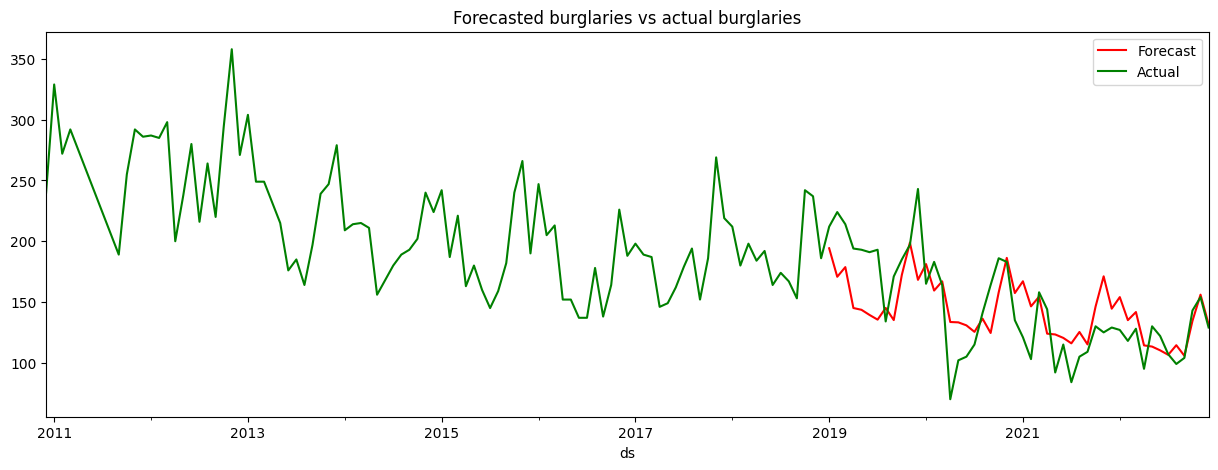

0.44627271206870966

In [29]:
# Train the model with the best parameters and forecast

best_model = Prophet(seasonality_mode= 'multiplicative', changepoint_prior_scale= 0.01, seasonality_prior_scale= 0.15, holidays_prior_scale= 0.015, holidays= holiday).fit(train_data)
future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
forecast = best_model.predict(future_dates)

# Plot predictions
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
monthly_grouped_df.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
plt.title('Forecasted burglaries vs actual burglaries')
plt.show()

r2_score(test_data['y'], forecast['yhat'][-forecast_upto:])


In [14]:
df_per_ward =  pd.read_csv('C:/Users/20203697/Downloads/filtered_df_utility_cols.csv')

df_per_ward['Ward'].unique()
df_per_ward['y'] = df_per_ward['Burglary Rate']
df_per_ward['day'] = 1
df_per_ward = df_per_ward.reset_index()
df_per_ward = df_per_ward.rename(columns={'Month num': 'month', 'Year': 'year'})
print(df_per_ward.columns)
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])   
train_data_per_ward = df_per_ward[df_per_ward['year']<(training_upto+1)]
test_data_per_ward = df_per_ward[(df_per_ward['year']>training_upto)]

train_data_per_ward

Index(['index', 'Date', 'Ward', 'year', 'Reported by', 'Falls within',
       'Crime type', 'Month name', 'month', 'Burglary Rate', 'Codes',
       'Borough', 'Population', 'Hectares', 'Square Kilometres',
       'Population per hectare', 'Population per square kilometre',
       'Census population (2011)', 'Police Workforce', 'LAD code',
       'Mean Income (£)', 'Median Income (£)', 'y', 'day'],
      dtype='object')


,index,Date,Ward,year,Reported by,Falls within,Crime type,Month name,month,Burglary Rate,...,Population per hectare,Population per square kilometre,Census population (2011),Police Workforce,LAD code,Mean Income (£),Median Income (£),y,day,ds
0,0,2010-12,Brunswick Park,2010,Metropolitan Police Service,Metropolitan Police Service,Burglary,Dec,12,13,...,51.650914,NaN,16394.0,52509,E09000003,50690.000000,37370.000000,13,1,2010-12-01
1,1,2010-12,Burnt Oak,2010,Metropolitan Police Service,Metropolitan Police Service,Burglary,Dec,12,11,...,88.260659,NaN,18217.0,52509,E09000003,36700.000000,27410.000000,11,1,2010-12-01
2,2,2010-12,Childs Hill,2010,Metropolitan Police Service,Metropolitan Police Service,Burglary,Dec,12,10,...,64.904500,NaN,20049.0,52509,E09000003,49750.000000,36750.000000,10,1,2010-12-01
3,3,2010-12,East Barnet,2010,Metropolitan Police Service,Metropolitan Police Service,Burglary,Dec,12,11,...,43.009062,NaN,16137.0,52509,E09000003,50550.000000,37280.000000,11,1,2010-12-01
4,4,2010-12,East Finchley,2010,Metropolitan Police Service,Metropolitan Police Service,Burglary,Dec,12,18,...,63.347861,NaN,15989.0,52509,E09000003,52380.000000,38480.000000,18,1,2010-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,1467,2018-08,Woodhouse,2018,Metropolitan Police Service,Metropolitan Police Service,Burglary,Aug,8,8,...,67.285605,7180.321593,17575.0,40321,NaN,51021.977705,38168.415181,8,1,2018-08-01
1468,1468,2018-09,Woodhouse,2018,Metropolitan Police Service,Metropolitan Police Service,Burglary,Sep,9,4,...,67.285605,7180.321593,17575.0,40321,NaN,51021.909889,38168.370344,4,1,2018-09-01
1469,1469,2018-10,Woodhouse,2018,Metropolitan Police Service,Metropolitan Police Service,Burglary,Oct,10,9,...,67.285605,7180.321593,17575.0,40321,NaN,51021.842072,38168.325506,9,1,2018-10-01
1470,1470,2018-11,Woodhouse,2018,Metropolitan Police Service,Metropolitan Police Service,Burglary,Nov,11,15,...,67.285605,7180.321593,17575.0,40321,NaN,51021.774256,38168.280669,15,1,2018-11-01


      index     Date            Ward  year                  Reported by  \
0         0  2010-12  Brunswick Park  2010  Metropolitan Police Service   
1         1  2010-12       Burnt Oak  2010  Metropolitan Police Service   
2         2  2010-12     Childs Hill  2010  Metropolitan Police Service   
3         3  2010-12     East Barnet  2010  Metropolitan Police Service   
4         4  2010-12   East Finchley  2010  Metropolitan Police Service   
...     ...      ...             ...   ...                          ...   
1467   1467  2018-08       Woodhouse  2018  Metropolitan Police Service   
1468   1468  2018-09       Woodhouse  2018  Metropolitan Police Service   
1469   1469  2018-10       Woodhouse  2018  Metropolitan Police Service   
1470   1470  2018-11       Woodhouse  2018  Metropolitan Police Service   
1471   1471  2018-12       Woodhouse  2018  Metropolitan Police Service   

                     Falls within Crime type Month name  month  Burglary Rate  \
0     Metropolitan

16:14:14 - cmdstanpy - INFO - Chain [1] start processing
16:14:14 - cmdstanpy - INFO - Chain [1] done processing


0.11212190309686387


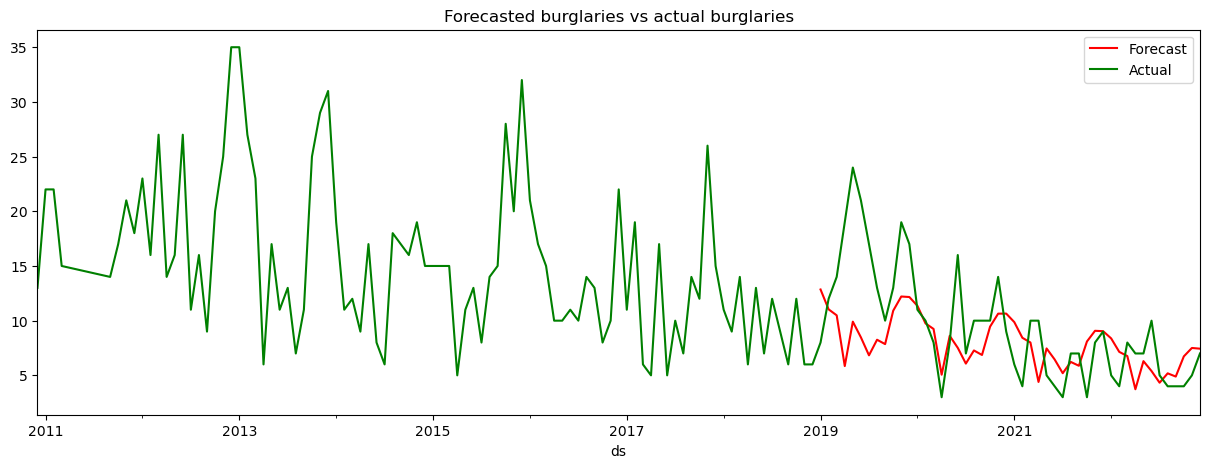

Burnt Oak


16:14:15 - cmdstanpy - INFO - Chain [1] start processing
16:14:15 - cmdstanpy - INFO - Chain [1] done processing


0.19531471766995723


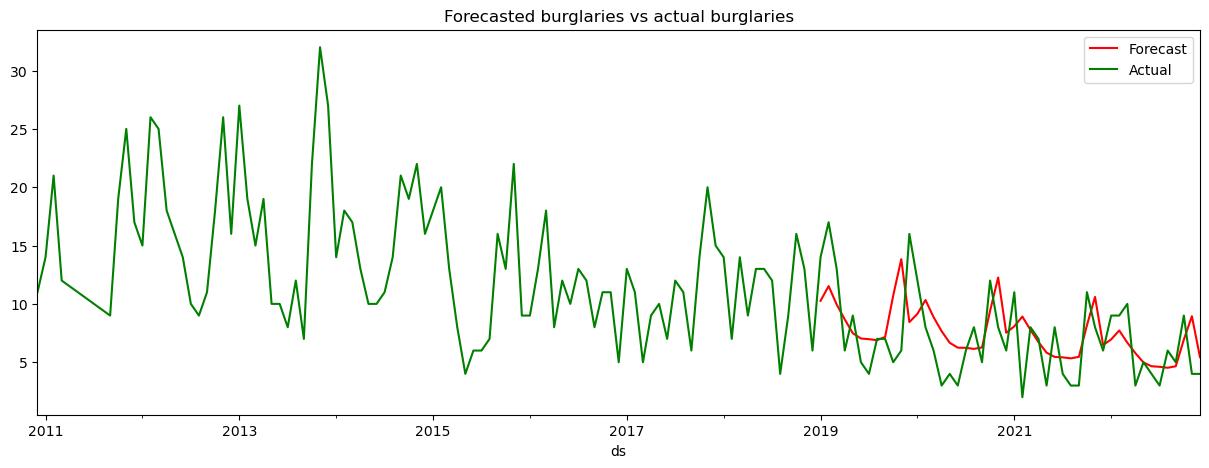

Childs Hill


16:14:16 - cmdstanpy - INFO - Chain [1] start processing
16:14:16 - cmdstanpy - INFO - Chain [1] done processing


-0.2874243355445927


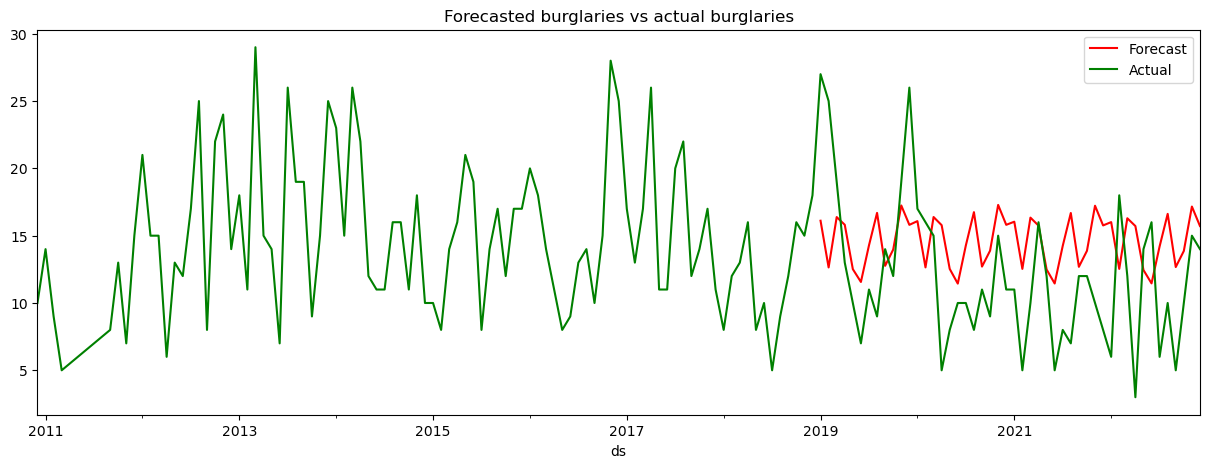

East Barnet


16:14:17 - cmdstanpy - INFO - Chain [1] start processing
16:14:17 - cmdstanpy - INFO - Chain [1] done processing


-0.3594749772971604


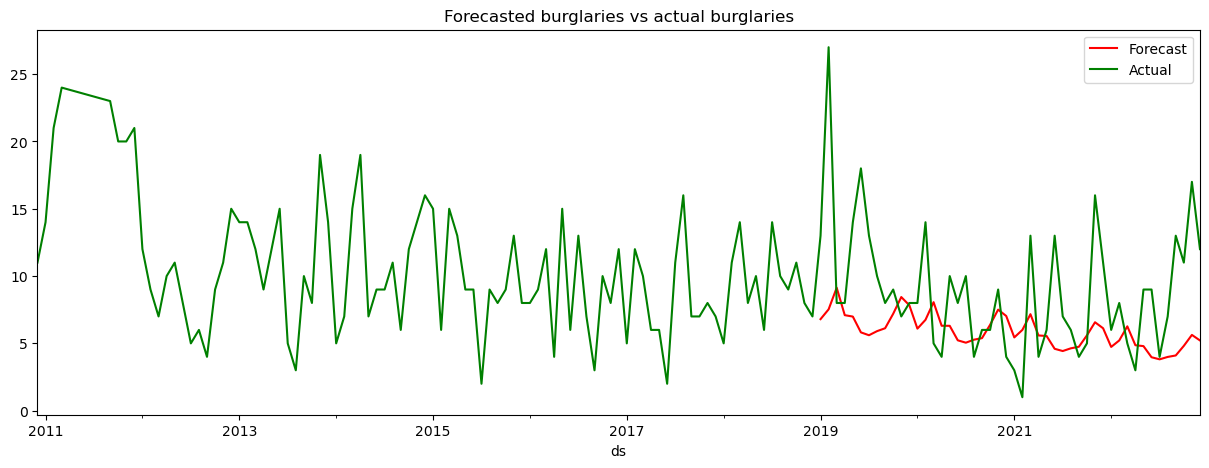

East Finchley


16:14:18 - cmdstanpy - INFO - Chain [1] start processing
16:14:18 - cmdstanpy - INFO - Chain [1] done processing


0.16170782894013236


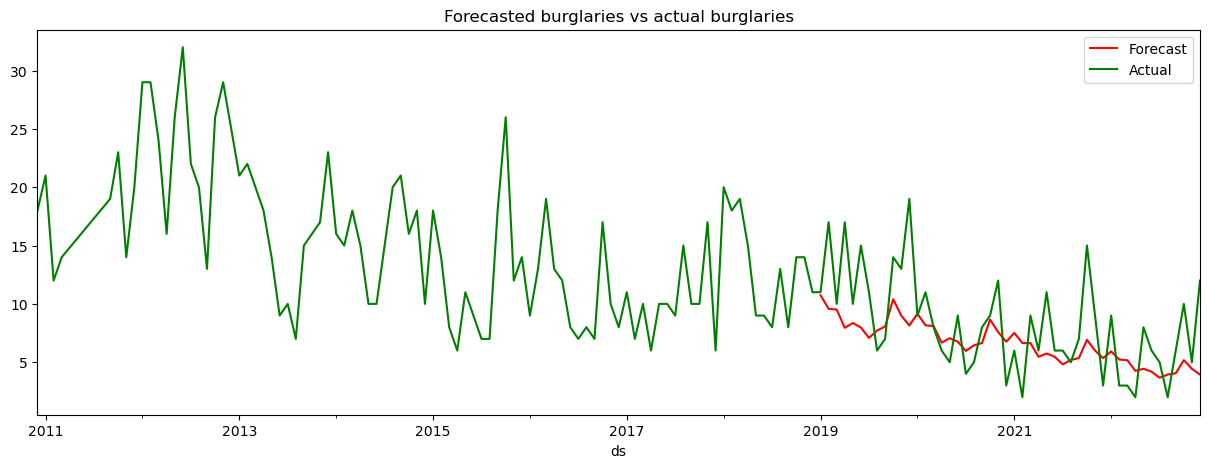

Edgware


16:14:19 - cmdstanpy - INFO - Chain [1] start processing
16:14:19 - cmdstanpy - INFO - Chain [1] done processing


-0.13957153333436212


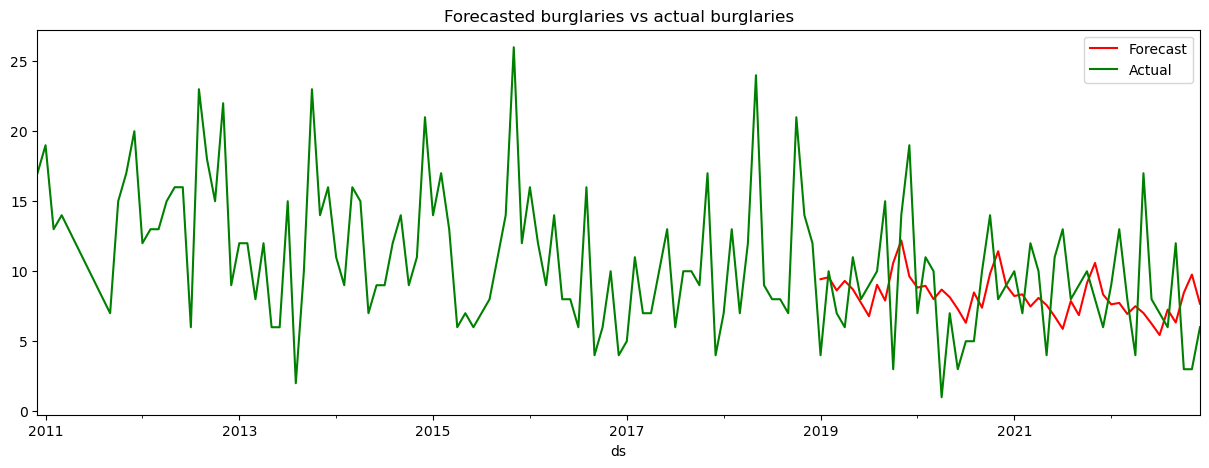

Finchley Church End


16:14:20 - cmdstanpy - INFO - Chain [1] start processing
16:14:20 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Found input variables with inconsistent numbers of samples: [45, 48]

In [18]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023, 2024]).items()):
    #holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0]), ignore_index=True)
    holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

wards = ['Brunswick Park', 'Burnt Oak', 'Childs Hill', 'East Barnet',
       'East Finchley', 'Edgware', 'Finchley Church End', 'Garden Suburb',
       'Golders Green', 'Hendon', 'High Barnet', 'Mill Hill', 'Underhill',
       'West Finchley', 'West Hendon', 'Woodhouse']
print(train_data_per_ward)
for ward in wards: 
       print(ward)
       best_model = Prophet(seasonality_mode= 'multiplicative', changepoint_prior_scale= 0.01, seasonality_prior_scale= 0.15, holidays_prior_scale= 0.015, holidays= holiday).fit(train_data_per_ward[train_data_per_ward['Ward']==ward])
       future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
       forecast = best_model.predict(future_dates)
       print(r2_score(test_data_per_ward[test_data_per_ward['Ward']==ward]['y'], forecast['yhat'][-forecast_upto:]))
       f, ax = plt.subplots(figsize=(14,5))
       f.set_figheight(5)
       f.set_figwidth(15)
       forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
       df_per_ward[df_per_ward['Ward']==ward].plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
       plt.title('Forecasted burglaries vs actual burglaries')
       plt.show()
       